In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"]= "1" # backward compatibility

In [2]:
import matplotlib.pyplot as plt

from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.metrics import r2_score, r2_UIVE

from goodman_panels import panels, panel_specs, label_panel, label_panels


In [3]:
dataset_names = ['chewie_09_15', 'chewie_09_21', 'chewie_10_05', 'chewie_10_07',
                 'mihili_02_03', 'mihili_02_17', 'mihili_02_18', 'mihili_03_07']
model_str='kl1_gauss_bd_d20_causal_ci'

bin_size_ms = 10

N_FOLDS = 5

In [4]:
dataset_dests = [f"/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/{dataset_name}" for dataset_name in dataset_names]

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_lens = [102,103,100,101,92,85,86,87] #101
encod_data_dims = [309,303,244,207,114,148,159,92]
seed = 2
model_names = [f'{model_name}_both_{fac_dim}f_{model_str}' for model_name in ['lfads','band']]
model_dests = [[f"{models_dest}/{model_name}" for model_name in model_names] for models_dest in dataset_dests]

model_dests


[['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_15/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_15/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_21/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_21/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_05/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_05/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_07/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_07/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/mihili_02_03/lfads_both_100f_kl1

In [5]:
# model_dests[0][-1] = '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'
# model_dests[0] = [f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}_cv{cv}/lfads_both_8f_4c_kl1_gauss_bd05" for cv in range(N_FOLDS)]
model_dests

[['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_15/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_15/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_21/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_09_21/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_05/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_05/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_07/lfads_both_100f_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/chewie_10_07/band_both_100f_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/pbt-causal-go/mihili_02_03/lfads_both_100f_kl1

In [6]:
from plot_helpers import get_random_trials2plot

def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

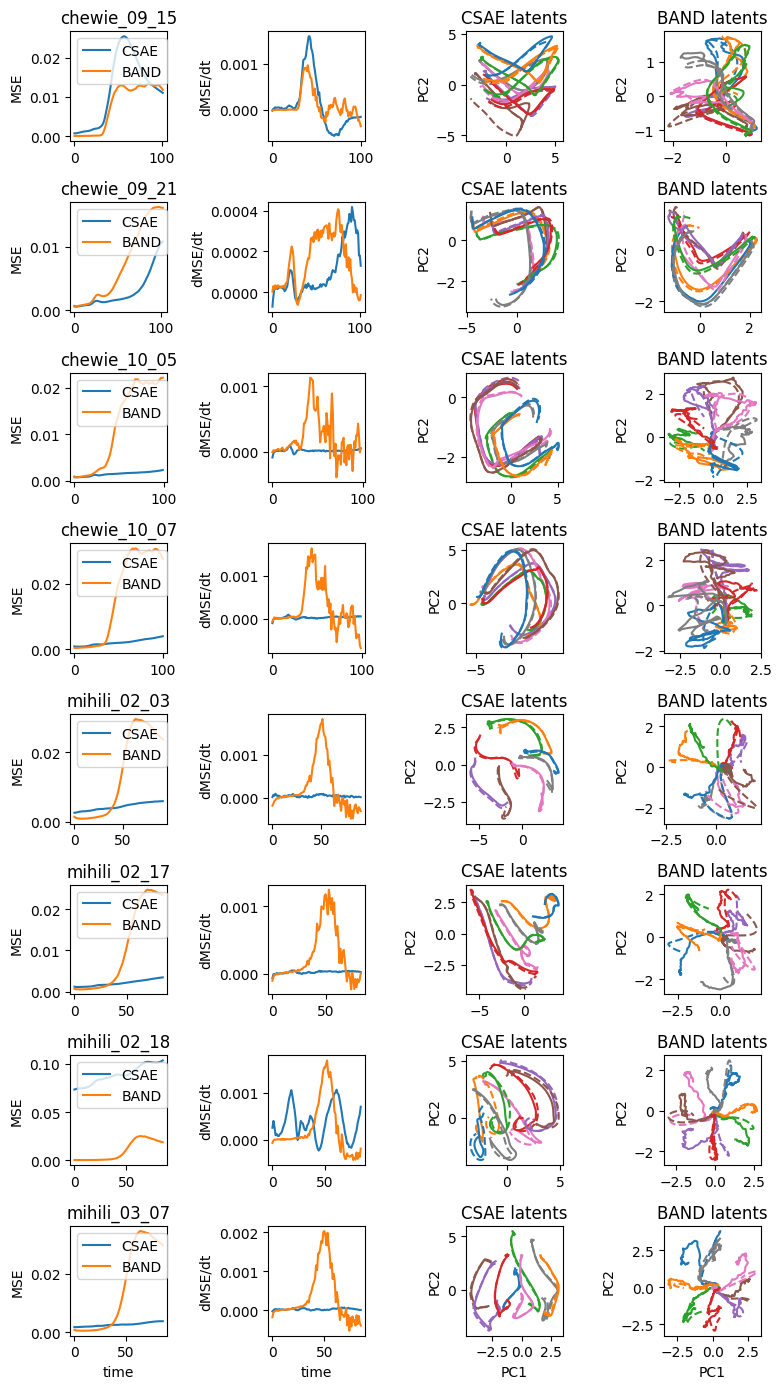

In [9]:

fig, all_axes = plt.subplots(8,4,figsize=(8,14))

for j,model_dest_pair in enumerate(model_dests):
    
    axes = all_axes[j]
    
    for i,model_dest in enumerate(model_dest_pair):

        data_path = os.path.join(model_dest,'best_model',f'lfads_output_go.h5')
        with h5py.File(data_path) as f:
            # print(f.keys())
            train_factors = f["train_factors"][:]
            factors = f["valid_factors"][:]
            target_dir = f["valid_target_direction"][:]
            epochs = f["valid_epoch"][:]
            ic = f['valid_gen_init'][:]
        data_path = os.path.join(model_dest,'best_model',f'lfads_W_ablated_output_go.h5')
        with h5py.File(data_path) as f:
            factors_noci = f["valid_factors"][:]

        dir_index = get_target_ids(target_dir)
        t2p = get_random_trials2plot(dir_index, epochs.astype('int'), 1)
        
        factors_diff = ((factors - factors_noci)**2).mean(0).mean(-1)
        # factors_diff /= factors_diff.std()
        model_name = model_dest.split('/')[-1].split('_')[0]
        if model_name == 'band':
            model_name = 'BAND'
        elif model_name == 'lfads':
            model_name = 'CSAE'
        else:
            raise ValueError(f'Unknown model name {model_name}')
        axes[0].plot(factors_diff,label = model_name,c=f'C{i}')
        axes[0].set_title(model_dest.split('/')[-2])
        axes[0].set_ylabel('MSE')

        axes[1].plot(np.diff(factors_diff),c=f'C{i}')
        axes[1].set_ylabel('dMSE/dt')

        pca = PCA(n_components=2)
        pca.fit(train_factors.reshape(-1,factors.shape[-1]))
        latents_full_pca = pca.transform(factors.reshape(-1,factors.shape[-1])).reshape(*factors.shape[:2],-1)
        latents_noci_pca = pca.transform(factors_noci.reshape(-1,factors_noci.shape[-1])).reshape(*factors.shape[:2],-1)
    
        for t in np.where(t2p)[0]:
            axes[2+i].plot(*latents_full_pca[t].T,linestyle='solid',c=f'C{dir_index[t]}')
            axes[2+i].plot(*latents_noci_pca[t].T,linestyle='dashed',c=f'C{dir_index[t]}')
        
        axes[2+i].set_title(f'{model_name} latents')
        axes[2+i].set_ylabel('PC2')

        if j==7:
            axes[0].set_xlabel('time')
            axes[1].set_xlabel('time')
            axes[2+i].set_xlabel('PC1')
                            
    axes[0].legend(loc='upper left')
    
plt.tight_layout()
plt.savefig('figs/latent_divergence.pdf')

In [43]:
# import lfads_torch
# import torch
# from hydra.utils import instantiate
# from pathlib import Path
# import hydra

# from lfads_torch.band_utils import flatten

# models = []
# for dataset_name,model_dest,encod_data_dim,encod_seq_len in zip(dataset_names, model_dests,encod_data_dims,encod_seq_lens):

#     overrides={
#             "datamodule": dataset_name,
#             "model": model_str, # older models were run with list of beh decoders
#             "model.encod_seq_len": encod_seq_len,
#             "model.recon_seq_len": encod_seq_len,
#             "model.kl_co_scale": float(encod_seq_len),
#             "model.fac_dim": fac_dim,
#             "model.co_dim": co_dim,
#             "model.encod_data_dim": encod_data_dim,
#             # "model.behavior_weight": bw,
#         }
#     # config_path="../../configs/pbt.yaml"
#     config_path="../../configs/single.yaml"
#     print(config_path)

#     # Compose the train config with properly formatted overrides
#     config_path = Path(config_path)
#     overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
#     with hydra.initialize(
#         config_path=config_path.parent,
#         job_name="get_weights",
#         version_base="1.1",
#     ):
#         config = hydra.compose(config_name=config_path.name, overrides=overrides)

#     # Instantiate `LightningDataModule` and `LightningModule`
#     datamodule = instantiate(config.datamodule, _convert_="all")
#     model = instantiate(config.model)

#     from glob import glob
#     checkpoint_folders = glob(model_dest+'/best_model/checkpoint*')

#     ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
#     # ckpt_path = f'{model_dest}/lightning_checkpoints/last.ckpt'
#     model.load_state_dict(torch.load(ckpt_path)["state_dict"])

#     models.append(model)

## PCA latent spaces

(581, 99, 100)
(581, 99, 100)


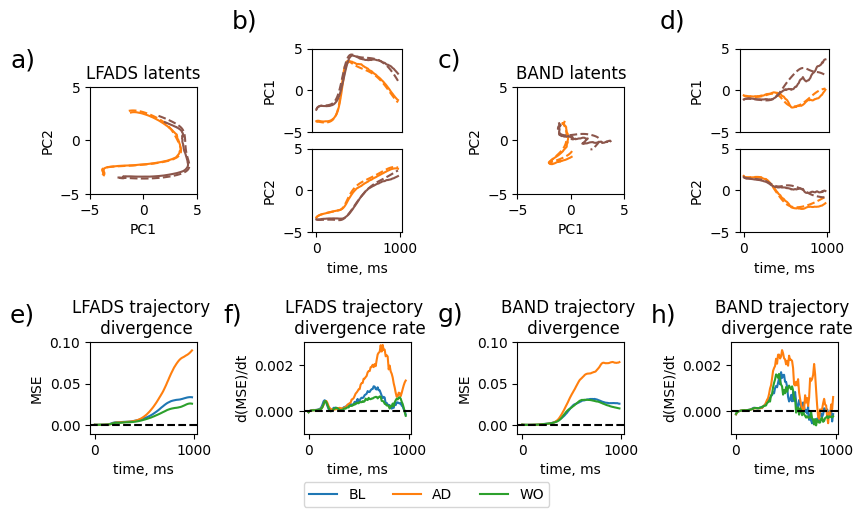

In [15]:
layout = '''
abcd
efgh
'''

fig = plt.figure(figsize=(8.5, 5))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, 
                        gridspec_args={'left': 0.1, 
                                       'right': .98, 
                                       'bottom': 0.15, 
                                       'top': 0.92, 
                                       'hspace': .8, 
                                       'wspace': 1})
axes = {}

w_ratios = [1,1,1,1]
h_ratios = [2,1]
gs.set_width_ratios(w_ratios)
gs.set_height_ratios(h_ratios)

for letter in 'acefgh':
    axes[letter] = ax = fig.add_subplot(specs[letter])
    label_panel(ax, letter, postfix=')')

subgs = specs['b'].subgridspec(2, 1, wspace=2.)
for j in range(2):
    axes[f"b{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['b0'], 'b', postfix=')')

subgs = specs['d'].subgridspec(2, 1, wspace=2.)
for j in range(2):
    axes[f"d{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['d0'], 'd', postfix=')')

from sklearn.decomposition import PCA

for model_label, latents_full, latents_noci, axes_letters in \
                                            zip(['LFADS','BAND'],
                                                [concat_factors[0], concat_factors[1]],
                                                [concat_factors_noci[0], concat_factors_noci[1]],
                                                ['abef','cdgh']):


    pca = PCA(n_components=2)
    pca.fit(latents_full.reshape(-1,latents_full.shape[-1]))
    print(latents_full.shape)
    latents_full_pca = pca.transform(latents_full.reshape(-1,latents_full.shape[-1])).reshape(*latents_full.shape[:2],-1)
    latents_noci_pca = pca.transform(latents_noci.reshape(-1,latents_noci.shape[-1])).reshape(*latents_full.shape[:2],-1)

    ax_a = axes[axes_letters[0]]
    ax_b0 = axes[axes_letters[1]+'0']
    ax_b1 = axes[axes_letters[1]+'1']
    ax_e = axes[axes_letters[2]]
    ax_f = axes[axes_letters[3]]

    mask = (concat_epochs==1) & (t2p==1)
    for t,at,d in zip(latents_full_pca[mask], 
                    latents_noci_pca[mask],
                    dir_index[mask]):
        if d in select:
            c = f"C{d}"
            ax_a.plot(t[:,0],t[:,1],c=c)
            ax_a.plot(at[:,0],at[:,1],c=c,linestyle='--')

            ax_b0.plot(10*np.arange(t.shape[0]),t[:,0],c=c)
            ax_b0.plot(10*np.arange(t.shape[0]),at[:,0],c=c,linestyle='--')

            ax_b1.plot(10*np.arange(t.shape[0]),t[:,1],c=c)
            ax_b1.plot(10*np.arange(t.shape[0]),at[:,1],c=c,linestyle='--')


    for e, epoch_name in enumerate(['BL','AD','WO']):
        MSE = np.mean((latents_full - latents_noci)**2,-1)[concat_epochs==e]
        ax_e.plot(np.arange(MSE.shape[1])*10,MSE.mean(0))
        mse_diff = MSE[:,1:] - MSE[:,:-1]
        ax_f.plot(np.arange(MSE.shape[1]-1)*10,mse_diff.mean(0),label=epoch_name)
    ax_e.axhline(0,c='k',linestyle='--')
    ax_f.axhline(0,c='k',linestyle='--')
    ax_e.set_title(f'{model_label} trajectory \n divergence')
    ax_f.set_title(f'{model_label} trajectory \n divergence rate')

    for letter in ['e','g']:
        axes[letter].set_ylim([-0.01,0.1])
        axes[letter].set_xlabel('time, ms')
        axes[letter].set_ylabel('MSE')

    for letter in ['f','h']:
        axes[letter].set_ylim([-0.001,0.003])
        axes[letter].set_xlabel('time, ms')
        axes[letter].set_ylabel('d(MSE)/dt')

    for letter in ['a','c']:
        axes[letter].set_xlim([-5,5])
        axes[letter].set_ylim([-5,5])
        axes[letter].set_aspect('equal')
        axes[letter].set_xlabel('PC1')
        axes[letter].set_ylabel('PC2')

    for letter in ['b','d']:
        for i in [0,1]:
            axes[letter+str(i)].set_ylabel('PC'+str(i+1))
            axes[letter+str(i)].set_aspect(100)
            axes[letter+str(i)].set_ylim([-5,5])
        axes[letter+str(1)].set_xlabel('time, ms')
        axes[letter+str(0)].set_xticks([])


axes['a'].set_title('LFADS latents')
axes['c'].set_title('BAND latents')
axes['f'].legend(loc=(0,-.8),ncol=3)

fig.savefig('figs/sfig4_trajectory_divergence.pdf')

